## 3DCNN model evalutaion

In [1]:
import pandas as pd
import joblib as jbl
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelEncoder

## Sampling -> Magnification -> Optical Flow

### Split

In [2]:
def get_train_test_indeces(Y_path, test_subjects: int = None, shuffle: bool = True, test_size: float = None):
    labels = pd.read_csv(Y_path, index_col="Unnamed: 0")
    test_idx = None
    train_idx = None
    indeces = np.arange(len(labels))
    if shuffle:
        np.random.seed(255) 
        np.random.shuffle(indeces)
    unique_groups = None
    if "subject" in labels.columns and test_subjects:
        groups = labels["subject"].values
        unique_groups = np.unique(groups)
        test_groups = np.random.choice(unique_groups, size=test_subjects, replace=False)
        test_mask = labels["subject"].isin(test_groups)
        size = sum(test_mask) / len(test_mask)
        if test_size != None:
            while abs(test_size - size) > 0.05:
                test_groups = np.random.choice(unique_groups, size=test_subjects, replace=False)
                test_mask = labels["subject"].isin(test_groups)
                size = sum(test_mask) / len(test_mask)
        train_idx = labels.index[~test_mask]
        test_idx = labels.index[test_mask]
    else:
        test_start = int((1-test_size) * len(labels))
        train_idx = indeces[0:test_start]
        test_idx = indeces[test_start:]

    if "subject" in labels.columns:
        labels.drop("subject", axis=1, inplace=True)

    return train_idx, test_idx, labels

train_idx, test_idx, labels = get_train_test_indeces("../data/union+subject.csv", shuffle=True, test_subjects=None, test_size=0.2)
display(labels.head(5))

,AU5,AU24,AU43,AU64,AU17,AU7,AU1,AU20,AU39,AU6,...,AU15,AU12,AU16,AU63,AU10,AU45,AU26,AU9,AU25,emotion
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,happiness
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,others
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,others
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,others
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,others


In [3]:
data_casme = jbl.load("../data/casme_mag_of.pkl")
print(data_casme.shape)
data_4dme = jbl.load("../data/4dme_mag_of.pkl")
print(data_4dme.shape)
concatted = np.concatenate([data_casme, data_4dme], axis=0)
print(concatted.shape)

(256, 7, 224, 224, 3)
(267, 7, 224, 224, 3)
(523, 7, 224, 224, 3)


In [4]:
labels["emotion"] = labels["emotion"].apply(lambda x: x.lower())
NUM_EMOTIONS = len(labels["emotion"].unique())
NUM_AUS = len(labels.columns[1:])
NUM_FRAMES = concatted.shape[1]
Y_SCALE = concatted.shape[2]
X_SCALE = concatted.shape[3]
CHANNELS = 1 if len(concatted.shape) <= 4 else concatted.shape[4]
le = LabelEncoder()
le.fit(labels["emotion"])
emotions = le.transform(labels["emotion"])
aus = labels[labels.columns[:-1]].to_numpy()
DATA_SIZE = concatted.shape[0]

We need to alter the class weights for emotions

In [5]:
emotion_counts = labels["emotion"].value_counts()
display(emotion_counts)
display(labels[labels.columns[:-1]].sum())
inverse_freq = 1 / emotion_counts.values
inverse_freq = np.ceil(15 * (inverse_freq / np.max(inverse_freq)))
codes = le.transform(emotion_counts.keys())
arg_sorted = np.argsort(codes)
class_weights = inverse_freq[arg_sorted]

emotion
others                 130
negative               127
disgust                 64
surprise                54
positive                34
repression              33
happiness               32
surprise+positive       14
surprise+negative        8
positive+repression      8
sadness                  7
negative+repression      7
surprise+repression      3
fear                     2
Name: count, dtype: int64

AU5      10
AU24     11
AU43      1
AU64      1
AU17     36
AU7     128
AU1      72
AU20      3
AU39      4
AU6      38
AU4     232
AU2      76
AU38      2
AU18      1
AU14     31
AU15     22
AU12     87
AU16      1
AU63      2
AU10     18
AU45     34
AU26      1
AU9      14
AU25      2
dtype: int64

In [6]:
training = tf.data.Dataset.from_tensor_slices((concatted[train_idx], (emotions[train_idx], aus[train_idx]))).shuffle(buffer_size=len(train_idx), seed=255).batch(1).prefetch(tf.data.AUTOTUNE)
validation = tf.data.Dataset.from_tensor_slices((concatted[test_idx], (emotions[test_idx], aus[test_idx]))).batch(1).prefetch(tf.data.AUTOTUNE)
'''
dataset = tf.data.Dataset.from_tensor_slices((concatted, (emotions, aus))).shuffle(buffer_size=DATA_SIZE, seed = 255).batch(1)
validation = dataset.skip(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)
training = dataset.take(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)
'''

'\ndataset = tf.data.Dataset.from_tensor_slices((concatted, (emotions, aus))).shuffle(buffer_size=DATA_SIZE, seed = 255).batch(1)\nvalidation = dataset.skip(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)\ntraining = dataset.take(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)\n'

In [7]:
class_weights = tf.cast(tf.constant(class_weights), dtype=tf.float32)

def weighted_loss(y_true, y_pred):
    weight = tf.gather(class_weights, y_true)
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return loss * weight

def basic_block(inputs, filters, stride=(1,1,1)):

    x = tf.keras.layers.Conv3D(filters, (3,3,3), strides=stride, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv3D(filters, (1,3,3), strides=1, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    shortcut = inputs
    if stride != (1,1,1) or inputs.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv3D(filters, (3,3,3), strides=stride, padding="same")(inputs)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def make_blocks(inputs, filters, blocks, stride=(1,1,1)):
    x = basic_block(inputs, filters, stride=stride)
    for _ in range(1, blocks):
        x = basic_block(x, filters, stride=(1,1,1))
    return x

def video_encoder(input_shape=(8,224,224,3), pooling='avg'):
    video_in = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv3D(8, (3,7,7), strides=(1,2,2), padding="same")(video_in)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling3D((1,3,3), strides=(1,2,2), padding="same")(x)

    x = tf.keras.layers.Conv3D(16, (3,5,5), strides=(1,2,2), padding="same", activation="relu")(x)

    # spatiotemporal compression
    x = make_blocks(x, 32, blocks=1, stride=2)
    x = make_blocks(x, 64, blocks=1, stride=2)
    x = make_blocks(x, 128, blocks=1, stride =2)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Conv3D(256, (1,3,3), strides=1, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPool3D((1,3,3), strides=(1,2,2), padding="same")(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    if pooling == 'avg':
        x = tf.keras.layers.GlobalAveragePooling3D()(x)
    elif pooling == 'max':
        x = tf.keras.layers.GlobalMaxPooling3D()(x)
    else:
        x = tf.keras.layers.Flatten()(x)

    model = tf.keras.Model(video_in, x)
    return model

def build_3d_cnn(input_shape=(8, 112, 112, 1), num_emotions=7, num_aus=12, lstm_hidden=128, dropout_f = 0.4):

    T, H, W, C = input_shape
    video_in = tf.keras.layers.Input(shape=input_shape, name="video_in")  # (T, H, W, C)
    encoder = video_encoder(input_shape=(T, H,W,C), pooling=None)
    dropout = tf.keras.layers.Dropout(dropout_f)(encoder(video_in))
    dense = tf.keras.layers.Dense(lstm_hidden, activation="relu")(dropout)
    emotion_logits = tf.keras.layers.Dense(num_emotions, name="emotion_logits", activation="softmax")(dense)
    au_logits = tf.keras.layers.Dense(num_aus, name="au_logits", activation="sigmoid")(dense)

    model = tf.keras.Model(inputs=video_in, outputs=[emotion_logits, au_logits], name="3D_CNN") # au_logits]
    return model

#1.2kk parameters, showed 65% validation on motion magnification

Model: "3D_CNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 video_in (InputLayer)          [(None, 7, 224, 224  0           []                               
                                , 3)]                                                             
                                                                                                  
 model (Functional)             (None, 1024)         1085856     ['video_in[0][0]']               
                                                                                                  
 dropout_2 (Dropout)            (None, 1024)         0           ['model[0][0]']                  
                                                                                                  
 dense (Dense)                  (None, 128)          131200      ['dropout_2[0][0]']         

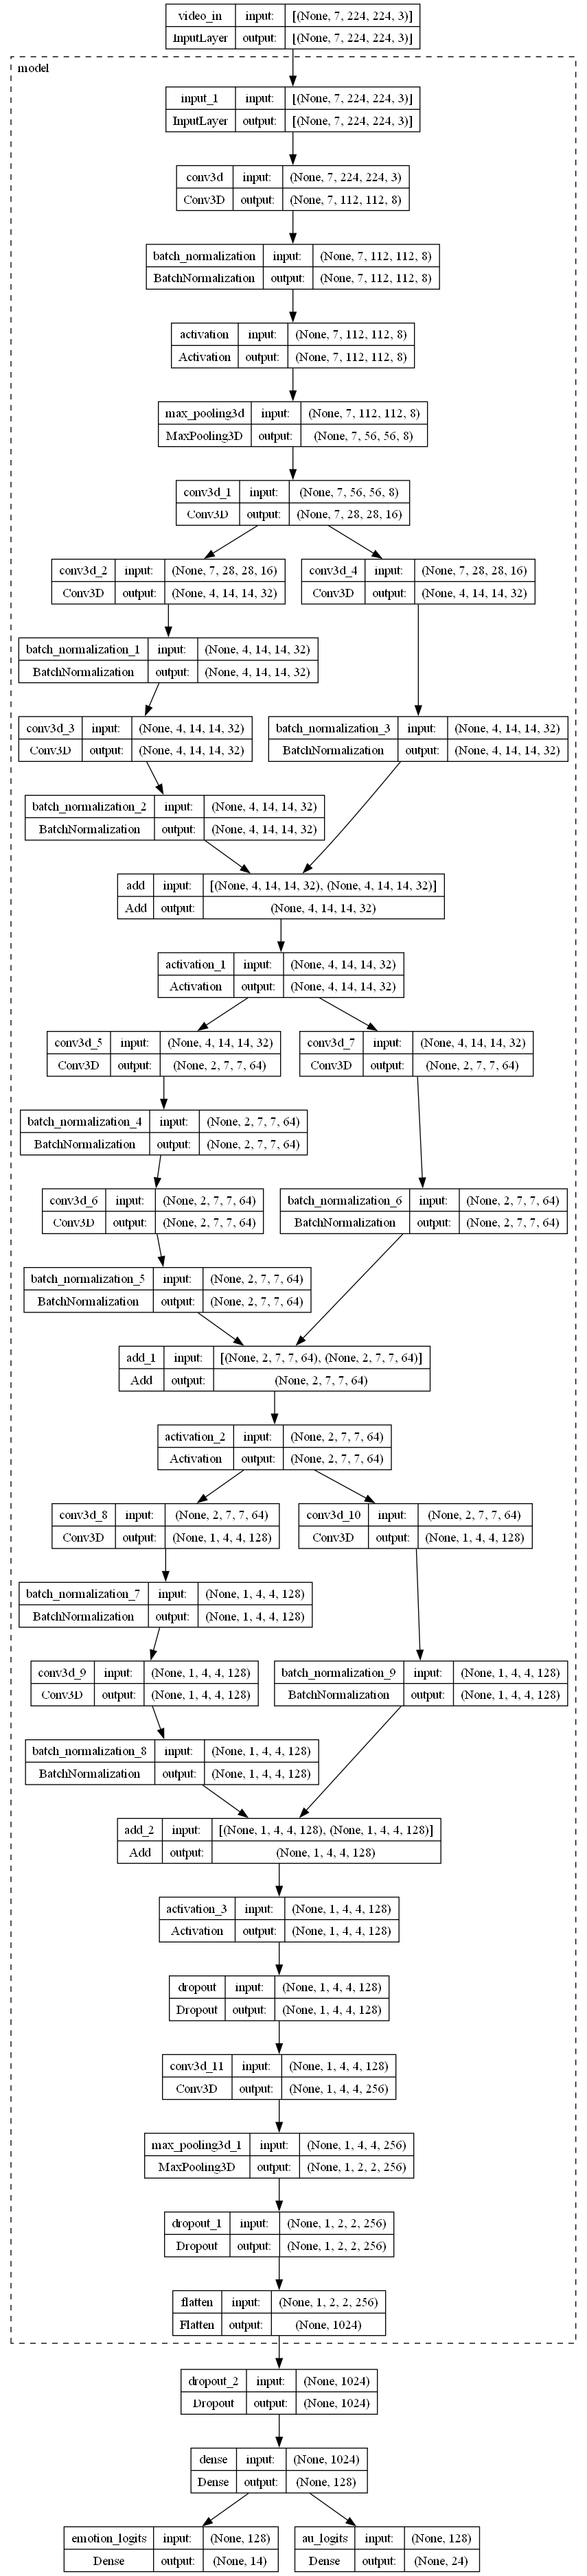

In [8]:
model = build_3d_cnn(input_shape=(NUM_FRAMES, Y_SCALE, X_SCALE, CHANNELS), num_emotions=NUM_EMOTIONS, num_aus=NUM_AUS)
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True,expand_nested=True)

### Using Focal Loss due to sparsity of AU vectors

In [9]:
EPOCHS = 30
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,      
    patience=3,       
    min_lr=1e-6,      
    verbose=1
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        "emotion_logits": weighted_loss,
        "au_logits": tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, gamma = 2) #tf.keras.losses.BinaryCrossentropy(from_logits=False)
    },
    metrics={
        "emotion_logits": tf.keras.metrics.SparseCategoricalAccuracy(),
         "au_logits": tf.keras.metrics.AUC(multi_label=True)
    },
    loss_weights={"emotion_logits": 1.0,
                  "au_logits": 2.0
     },
)
history = model.fit(training, validation_data=validation, epochs = EPOCHS, verbose=1, callbacks=lr_scheduler)

Epoch 1/30
418/418 [==============================] - 23s 32ms/step - loss: 4.9887 - emotion_logits_loss: 4.6404 - au_logits_loss: 0.1742 - emotion_logits_sparse_categorical_accuracy: 0.1699 - au_logits_auc: 0.4353 - val_loss: 3.1485 - val_emotion_logits_loss: 3.0407 - val_au_logits_loss: 0.0539 - val_emotion_logits_sparse_categorical_accuracy: 0.2571 - val_au_logits_auc: 0.3886 - lr: 1.0000e-04
Epoch 2/30
418/418 [==============================] - 12s 28ms/step - loss: 4.1562 - emotion_logits_loss: 4.0201 - au_logits_loss: 0.0681 - emotion_logits_sparse_categorical_accuracy: 0.1675 - au_logits_auc: 0.4869 - val_loss: 3.2295 - val_emotion_logits_loss: 3.1326 - val_au_logits_loss: 0.0485 - val_emotion_logits_sparse_categorical_accuracy: 0.1810 - val_au_logits_auc: 0.3716 - lr: 1.0000e-04
Epoch 3/30
418/418 [==============================] - 12s 28ms/step - loss: 3.6814 - emotion_logits_loss: 3.5850 - au_logits_loss: 0.0482 - emotion_logits_sparse_categorical_accuracy: 0.1890 - au_logits

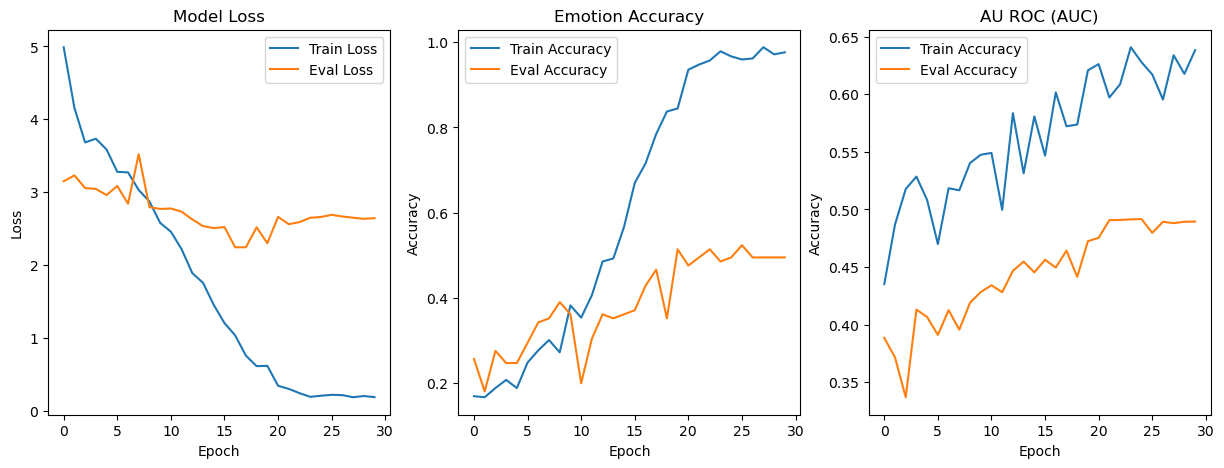

c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result

              precision    recall  f1-score   support

         AU5        nan       nan       nan         0
        AU24        nan      0.00      0.00         5
        AU43        nan       nan       nan         0
        AU64        nan       nan       nan         0
        AU17        nan      0.00      0.00         7
         AU7       0.43      0.14      0.21        21
         AU1       0.83      0.50      0.62        10
        AU20        nan       nan       nan         0
        AU39        nan      0.00      0.00         1
         AU6       0.00      0.00      0.00         4
         AU4       0.81      0.83      0.82        46
         AU2       0.57      0.36      0.44        11
        AU38        nan      0.00      0.00         1
        AU18        nan       nan       nan         0
        AU14       0.00      0.00      0.00         6
        AU15       1.00      0.33      0.50         3
        AU12        nan      0.00      0.00        19
        AU16        nan    

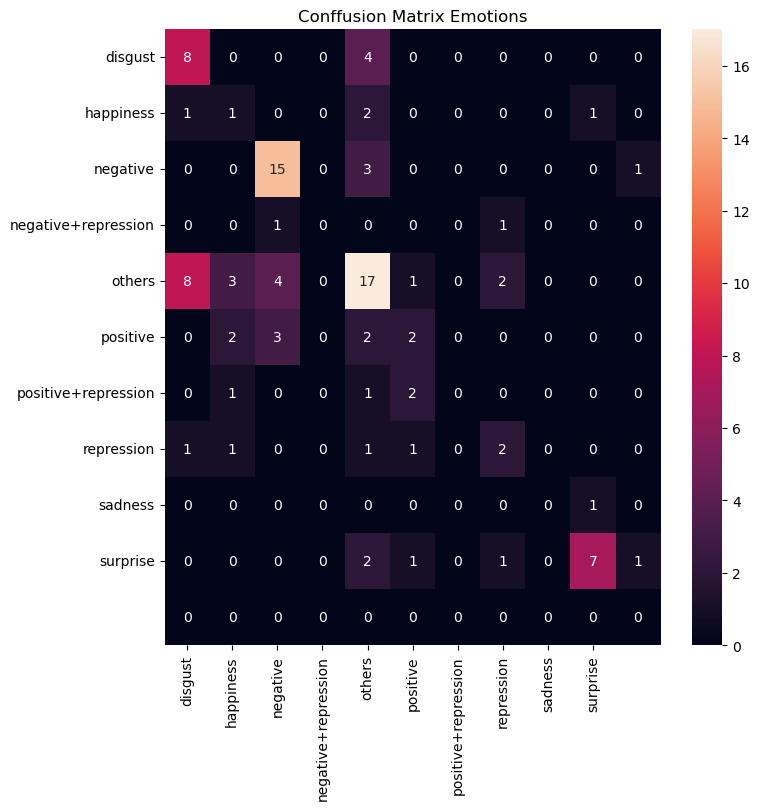

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def results(history, prefix = ""):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    emotion_train_accuracy = history.history['emotion_logits_sparse_categorical_accuracy']
    emotion_val_accuracy =  history.history['val_emotion_logits_sparse_categorical_accuracy']
    au_train_accuracy =  history.history['au_logits_auc'+ prefix]
    au_val_accuracy =  history.history['val_au_logits_auc'+ prefix]

    def plot_history(data_1, data_2, label, subplot, title):
        x = np.arange(EPOCHS)
        plt.subplot(1, 3, subplot)
        plt.plot(x, data_1, label = f"Train {label}")
        plt.plot(x, data_2, label = f"Eval {label}")
        plt.xlabel("Epoch")
        plt.ylabel(label)
        plt.legend()
        plt.title(title)

    plt.figure(figsize = (15, 5))
    plot_history(loss, val_loss, "Loss", 1, "Model Loss")
    plot_history(emotion_train_accuracy, emotion_val_accuracy, "Accuracy", 2, "Emotion Accuracy")
    plot_history(au_train_accuracy, au_val_accuracy, "Accuracy", 3, "AU ROC (AUC)")
    plt.show()

results(history, "")
def eval_model(validation_data, model):
    true_emotions = []
    true_AUs = []
    pred_emotions = []
    pred_AUs = []
    count = 0
    for video, (emotion, au_vector) in validation_data:
        count += 1
        true_emotions.append(emotion.numpy().squeeze())
        true_AUs.append(au_vector.numpy().squeeze())
        pred = model.predict(video, verbose = 0)
        pred_emotions.append(np.argmax(pred[0]))
        pred_AUs.append((pred[1] > 0.5).astype(np.int32).squeeze())
    cr_aus = classification_report(true_AUs, pred_AUs, target_names = labels.columns[:-1], zero_division=np.nan)
    pred_emotions = le.inverse_transform(pred_emotions)
    true_emotions = le.inverse_transform(true_emotions)
    cr_emotions = classification_report(true_emotions, pred_emotions)
    cm_emotions = confusion_matrix(true_emotions, pred_emotions)
    print(cr_aus)
    print(cr_emotions)
    plt.figure(figsize=(8,8))
    target_names_emotions =  np.unique(true_emotions)
    sns.heatmap(cm_emotions, annot=True, fmt= "d", xticklabels=target_names_emotions, yticklabels=target_names_emotions)
    plt.title("Conffusion Matrix Emotions")
    plt.show()

eval_model(validation, model)

## Sample -> Optical Flow

In [11]:
data_casme = jbl.load("../data/casme_optical_only.pkl")
print(data_casme.shape)
data_4dme = jbl.load("../data/4dme_optical_only.pkl")
print(data_4dme.shape)
concatted = np.concatenate([data_casme, data_4dme], axis=0)
print(concatted.shape)
NUM_FRAMES = concatted.shape[1]
Y_SCALE = concatted.shape[2]
X_SCALE = concatted.shape[3]
CHANNELS = 1 if len(concatted.shape) <= 4 else concatted.shape[4]

(256, 7, 224, 224, 3)
(267, 7, 224, 224, 3)
(523, 7, 224, 224, 3)


In [12]:
training = tf.data.Dataset.from_tensor_slices((concatted[train_idx], (emotions[train_idx], aus[train_idx]))).shuffle(buffer_size=len(train_idx), seed=255).batch(1).prefetch(tf.data.AUTOTUNE)
validation = tf.data.Dataset.from_tensor_slices((concatted[test_idx], (emotions[test_idx], aus[test_idx]))).batch(1).prefetch(tf.data.AUTOTUNE)
'''
dataset = tf.data.Dataset.from_tensor_slices((concatted, (emotions, aus))).shuffle(buffer_size=DATA_SIZE, seed = 255).batch(1)
validation = dataset.skip(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)
training = dataset.take(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)
'''

'\ndataset = tf.data.Dataset.from_tensor_slices((concatted, (emotions, aus))).shuffle(buffer_size=DATA_SIZE, seed = 255).batch(1)\nvalidation = dataset.skip(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)\ntraining = dataset.take(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)\n'

In [ ]:
model = build_3d_cnn(input_shape=(NUM_FRAMES, Y_SCALE, X_SCALE, CHANNELS), num_emotions=NUM_EMOTIONS, num_aus=NUM_AUS)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        "emotion_logits": weighted_loss,
        "au_logits": tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True) #target AU binary vectors are way too sparse, so this loss compensates this
    },
    metrics={
        "emotion_logits": tf.keras.metrics.SparseCategoricalAccuracy(),
         "au_logits": tf.keras.metrics.AUC(multi_label=True)
    },
    loss_weights={"emotion_logits": 1.0, "au_logits": 2.0
     },
)
history = model.fit(training, validation_data=validation, epochs = EPOCHS, verbose=1)

Epoch 1/30
418/418 [==============================] - 16s 30ms/step - loss: 5.0724 - emotion_logits_loss: 4.6559 - au_logits_loss: 0.2083 - emotion_logits_sparse_categorical_accuracy: 0.1722 - au_logits_auc_1: 0.4860 - val_loss: 3.2050 - val_emotion_logits_loss: 3.0380 - val_au_logits_loss: 0.0835 - val_emotion_logits_sparse_categorical_accuracy: 0.2190 - val_au_logits_auc_1: 0.4043 - lr: 1.0000e-04
Epoch 2/30
418/418 [==============================] - 11s 27ms/step - loss: 4.0640 - emotion_logits_loss: 3.9044 - au_logits_loss: 0.0798 - emotion_logits_sparse_categorical_accuracy: 0.1914 - au_logits_auc_1: 0.4512 - val_loss: 3.3801 - val_emotion_logits_loss: 3.2391 - val_au_logits_loss: 0.0705 - val_emotion_logits_sparse_categorical_accuracy: 0.0381 - val_au_logits_auc_1: 0.3336 - lr: 1.0000e-04
Epoch 3/30
418/418 [==============================] - 11s 27ms/step - loss: 3.9445 - emotion_logits_loss: 3.8230 - au_logits_loss: 0.0608 - emotion_logits_sparse_categorical_accuracy: 0.1675 - a

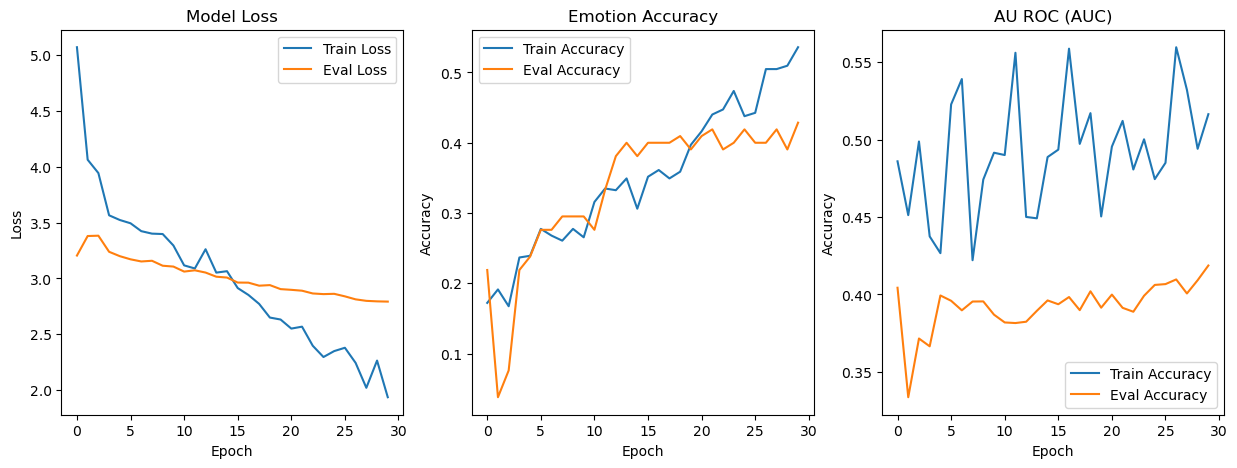

c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result

              precision    recall  f1-score   support

         AU5        nan       nan       nan         0
        AU24        nan      0.00      0.00         5
        AU43        nan       nan       nan         0
        AU64        nan       nan       nan         0
        AU17        nan      0.00      0.00         7
         AU7        nan      0.00      0.00        21
         AU1        nan      0.00      0.00        10
        AU20        nan       nan       nan         0
        AU39        nan      0.00      0.00         1
         AU6        nan      0.00      0.00         4
         AU4       1.00      0.13      0.23        46
         AU2        nan      0.00      0.00        11
        AU38        nan      0.00      0.00         1
        AU18        nan       nan       nan         0
        AU14        nan      0.00      0.00         6
        AU15        nan      0.00      0.00         3
        AU12       0.00      0.00      0.00        19
        AU16        nan    

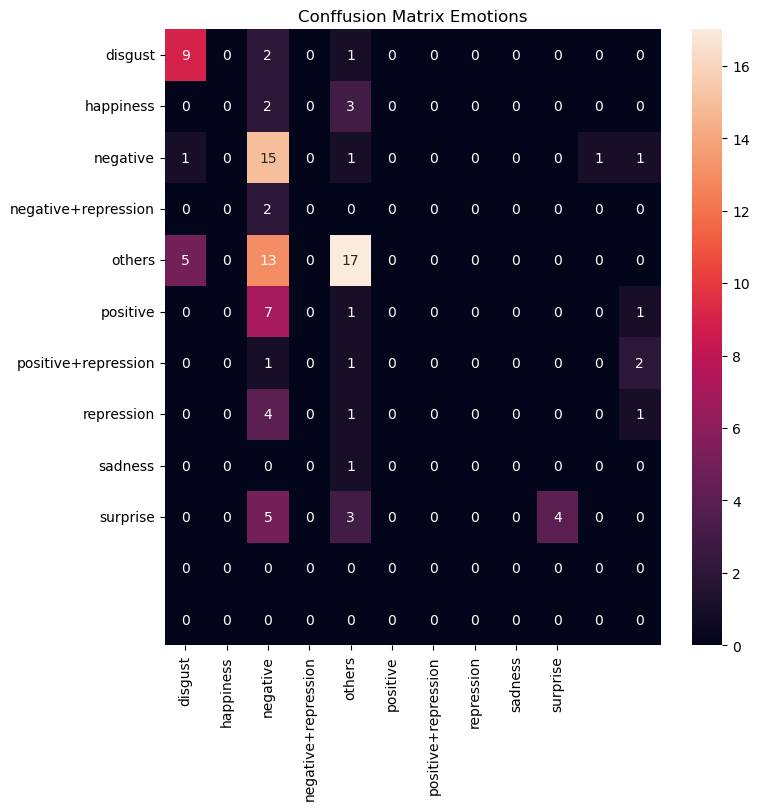

In [14]:
results(history, prefix = "_1")
eval_model(validation, model)

## Magnification -> Sample

In [15]:
data_casme = jbl.load("../data/casme_magnify_only.pkl")
print(data_casme.shape)
data_4dme = jbl.load("../data/4dme_magnify_only.pkl")
print(data_4dme.shape)
concatted = np.concatenate([data_casme, data_4dme], axis=0)
print(concatted.shape)
NUM_FRAMES = concatted.shape[1]
Y_SCALE = concatted.shape[2]
X_SCALE = concatted.shape[3]
CHANNELS = 1 if len(concatted.shape) <= 4 else concatted.shape[4]

(256, 8, 224, 224)
(267, 8, 224, 224)
(523, 8, 224, 224)


In [16]:
training = tf.data.Dataset.from_tensor_slices((concatted[train_idx], (emotions[train_idx], aus[train_idx]))).shuffle(buffer_size=len(train_idx), seed=255).batch(1).prefetch(tf.data.AUTOTUNE)
validation = tf.data.Dataset.from_tensor_slices((concatted[test_idx], (emotions[test_idx], aus[test_idx]))).batch(1).prefetch(tf.data.AUTOTUNE)
'''
dataset = tf.data.Dataset.from_tensor_slices((concatted, (emotions, aus))).shuffle(buffer_size=DATA_SIZE, seed = 255).batch(1)
validation = dataset.skip(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)
training = dataset.take(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)
'''

'\ndataset = tf.data.Dataset.from_tensor_slices((concatted, (emotions, aus))).shuffle(buffer_size=DATA_SIZE, seed = 255).batch(1)\nvalidation = dataset.skip(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)\ntraining = dataset.take(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)\n'

Epoch 1/30
418/418 [==============================] - 14s 26ms/step - loss: 4.9221 - emotion_logits_loss: 4.5694 - au_logits_loss: 0.1764 - emotion_logits_sparse_categorical_accuracy: 0.1722 - au_logits_auc_2: 0.4756 - val_loss: 3.3934 - val_emotion_logits_loss: 3.2504 - val_au_logits_loss: 0.0715 - val_emotion_logits_sparse_categorical_accuracy: 0.2095 - val_au_logits_auc_2: 0.3564 - lr: 1.0000e-04
Epoch 2/30
418/418 [==============================] - 10s 24ms/step - loss: 3.9130 - emotion_logits_loss: 3.7812 - au_logits_loss: 0.0659 - emotion_logits_sparse_categorical_accuracy: 0.2057 - au_logits_auc_2: 0.4444 - val_loss: 3.3682 - val_emotion_logits_loss: 3.2761 - val_au_logits_loss: 0.0460 - val_emotion_logits_sparse_categorical_accuracy: 0.1143 - val_au_logits_auc_2: 0.3313 - lr: 1.0000e-04
Epoch 3/30
418/418 [==============================] - 10s 24ms/step - loss: 3.8089 - emotion_logits_loss: 3.7109 - au_logits_loss: 0.0490 - emotion_logits_sparse_categorical_accuracy: 0.2464 - a

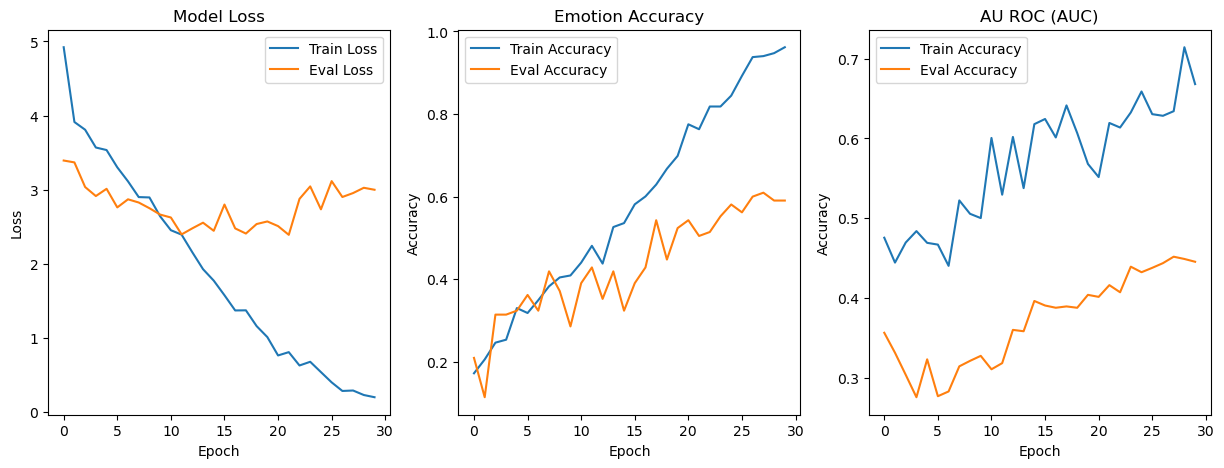

c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result

              precision    recall  f1-score   support

         AU5        nan       nan       nan         0
        AU24        nan      0.00      0.00         5
        AU43        nan       nan       nan         0
        AU64        nan       nan       nan         0
        AU17        nan      0.00      0.00         7
         AU7       1.00      0.05      0.09        21
         AU1       0.60      0.30      0.40        10
        AU20        nan       nan       nan         0
        AU39        nan      0.00      0.00         1
         AU6        nan      0.00      0.00         4
         AU4       0.88      0.63      0.73        46
         AU2       0.70      0.64      0.67        11
        AU38        nan      0.00      0.00         1
        AU18        nan       nan       nan         0
        AU14       0.00      0.00      0.00         6
        AU15        nan      0.00      0.00         3
        AU12       1.00      0.11      0.19        19
        AU16        nan    

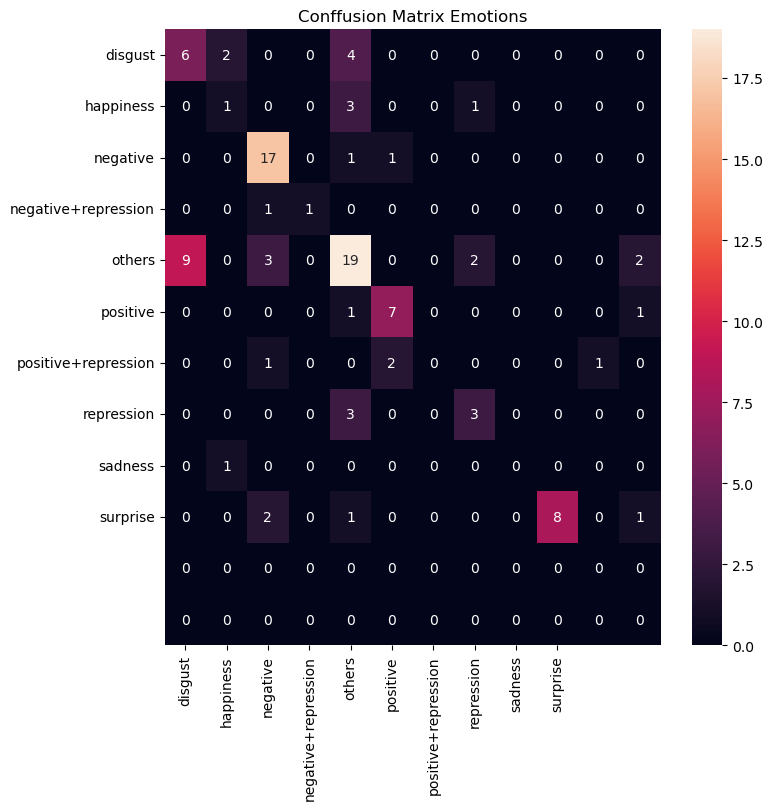

In [17]:
model = build_3d_cnn(input_shape=(NUM_FRAMES, Y_SCALE, X_SCALE, CHANNELS), num_emotions=NUM_EMOTIONS, num_aus=NUM_AUS)
def decay(epoch, lr):
    if epoch == 26:
        return lr * 0.1
    return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(decay)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        "emotion_logits": weighted_loss,
        "au_logits": tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True) #tf.keras.losses.BinaryCrossentropy(from_logits=False)
    },
    metrics={
        "emotion_logits": tf.keras.metrics.SparseCategoricalAccuracy(),
         "au_logits": tf.keras.metrics.AUC(multi_label=True)
    },
    loss_weights={"emotion_logits": 1.0, "au_logits": 2.0
     },
)
history = model.fit(training, validation_data=validation, epochs = EPOCHS, verbose=1, callbacks=lr_scheduler) # callbacks=lr_scheduler
results(history, prefix = "_2")
eval_model(validation, model)

## Early fusion of Optical flow + LBP

LBPs were computed after magnification and sampling, Optical flow after directly after sampling.

In [18]:
of_casme = jbl.load("../data/casme_optical_only.pkl")
print(of_casme.shape)
of_4dme = jbl.load("../data/4dme_optical_only.pkl")
print(of_4dme.shape)
lbp_casme = jbl.load("../data/casme_magnified_lbps.pkl")
print(lbp_casme.shape)
lbp_4dme = jbl.load("../data/4dme_magnified_lbps.pkl")
print(lbp_4dme.shape)
data_casme = np.concatenate([of_casme, lbp_casme[:, :-1,..., np.newaxis]], axis=-1)
data_4dme = np.concatenate([of_4dme, lbp_4dme[:, :-1,..., np.newaxis]], axis=-1)
concatted = np.concatenate([data_casme, data_4dme], axis=0)
print(concatted.shape)
NUM_FRAMES = concatted.shape[1]
Y_SCALE = concatted.shape[2]
X_SCALE = concatted.shape[3]
CHANNELS = 1 if len(concatted.shape) <= 4 else concatted.shape[4]

(256, 7, 224, 224, 3)
(267, 7, 224, 224, 3)
(256, 8, 224, 224)
(267, 8, 224, 224)
(523, 7, 224, 224, 4)


In [19]:
del data_casme
del data_4dme
del of_4dme 
del of_casme
del lbp_casme 
del lbp_4dme

In [20]:
training = tf.data.Dataset.from_tensor_slices((concatted[train_idx], (emotions[train_idx], aus[train_idx]))).shuffle(buffer_size=len(train_idx), seed=255).batch(1).prefetch(tf.data.AUTOTUNE)
validation = tf.data.Dataset.from_tensor_slices((concatted[test_idx], (emotions[test_idx], aus[test_idx]))).batch(1).prefetch(tf.data.AUTOTUNE)
'''
dataset = tf.data.Dataset.from_tensor_slices((concatted, (emotions, aus))).shuffle(buffer_size=DATA_SIZE, seed = 255).batch(1)
validation = dataset.skip(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)
training = dataset.take(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)
'''

'\ndataset = tf.data.Dataset.from_tensor_slices((concatted, (emotions, aus))).shuffle(buffer_size=DATA_SIZE, seed = 255).batch(1)\nvalidation = dataset.skip(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)\ntraining = dataset.take(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)\n'

Epoch 1/30
418/418 [==============================] - 16s 32ms/step - loss: 5.1641 - emotion_logits_loss: 4.7999 - au_logits_loss: 0.1821 - emotion_logits_sparse_categorical_accuracy: 0.1364 - au_logits_auc_3: 0.4590 - val_loss: 3.1642 - val_emotion_logits_loss: 3.0376 - val_au_logits_loss: 0.0633 - val_emotion_logits_sparse_categorical_accuracy: 0.2286 - val_au_logits_auc_3: 0.3480 - lr: 1.0000e-04
Epoch 2/30
418/418 [==============================] - 12s 29ms/step - loss: 4.0640 - emotion_logits_loss: 3.9285 - au_logits_loss: 0.0677 - emotion_logits_sparse_categorical_accuracy: 0.1722 - au_logits_auc_3: 0.4235 - val_loss: 3.3508 - val_emotion_logits_loss: 3.2483 - val_au_logits_loss: 0.0513 - val_emotion_logits_sparse_categorical_accuracy: 0.2000 - val_au_logits_auc_3: 0.3641 - lr: 1.0000e-04
Epoch 3/30
418/418 [==============================] - 12s 29ms/step - loss: 4.1026 - emotion_logits_loss: 4.0028 - au_logits_loss: 0.0499 - emotion_logits_sparse_categorical_accuracy: 0.1770 - a

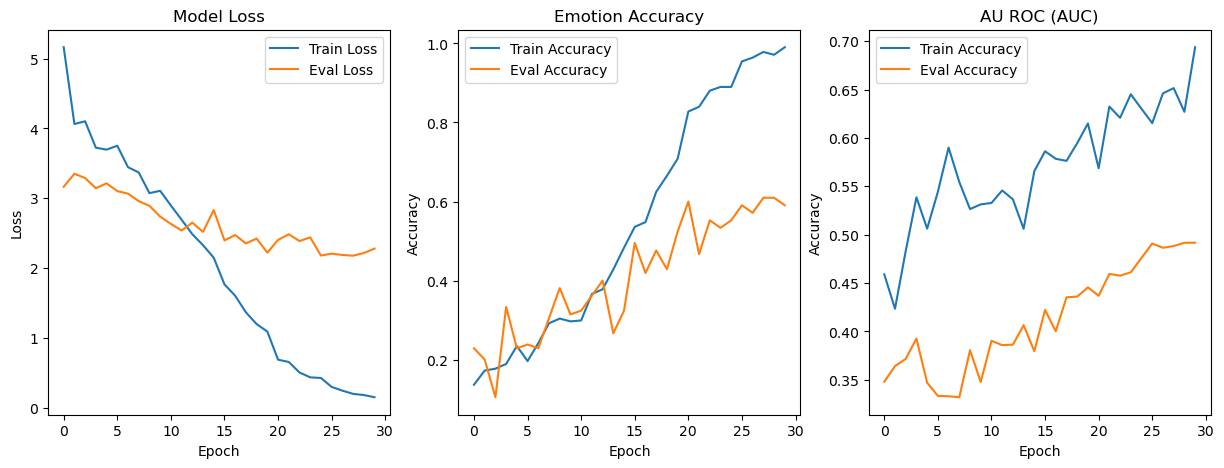

c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result

              precision    recall  f1-score   support

         AU5        nan       nan       nan         0
        AU24        nan      0.00      0.00         5
        AU43        nan       nan       nan         0
        AU64        nan       nan       nan         0
        AU17        nan      0.00      0.00         7
         AU7        nan      0.00      0.00        21
         AU1       0.83      0.50      0.62        10
        AU20        nan       nan       nan         0
        AU39        nan      0.00      0.00         1
         AU6        nan      0.00      0.00         4
         AU4       0.91      0.91      0.91        46
         AU2       0.80      0.36      0.50        11
        AU38        nan      0.00      0.00         1
        AU18        nan       nan       nan         0
        AU14        nan      0.00      0.00         6
        AU15        nan      0.00      0.00         3
        AU12       1.00      0.26      0.42        19
        AU16        nan    

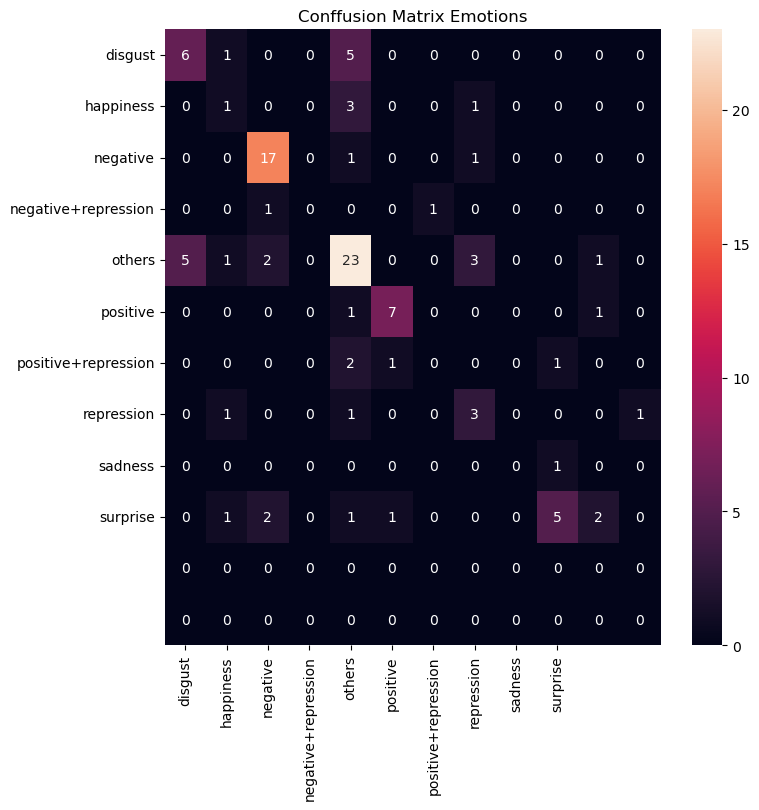

In [21]:
model = build_3d_cnn(input_shape=(NUM_FRAMES, Y_SCALE, X_SCALE, CHANNELS), num_emotions=NUM_EMOTIONS, num_aus=NUM_AUS)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        "emotion_logits": weighted_loss,
        "au_logits": tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True) #tf.keras.losses.BinaryCrossentropy(from_logits=False)
    },
    metrics={
        "emotion_logits": tf.keras.metrics.SparseCategoricalAccuracy(),
         "au_logits": tf.keras.metrics.AUC(multi_label=True)
    },
    loss_weights={"emotion_logits": 1.0, "au_logits": 2.0
     },
)
history = model.fit(training, validation_data=validation, epochs = EPOCHS, verbose=1, callbacks=lr_scheduler)
results(history, prefix = "_3")
eval_model(validation, model)